In [47]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import EarlyStopping

import splitfolders

In [13]:
splitfolders.ratio("imgClassfication", output="train_test_dataset", ratio=(.8, .2))

Copying files: 7000 files [00:44, 158.17 files/s]


In [79]:
# 사전 학습된 모델 불러오기

input_tensor = Input(shape=(224,224,3))
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

In [87]:
## Vgg16 model to layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

## Add Layer
x = layer_dict['block5_pool'].output
# Add Cov2D Layer
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
# Add MaxPooling2D Layer
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add Flatten Layer
x = Flatten()(x)
# Add FC Layer 
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Definition new model
new_model = Model(inputs = model.input, outputs = x)

In [88]:
new_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [89]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19]:
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
new_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [90]:
# 테스트 데이터 (고양이/강아지)
train_dir ='./train_test_dataset/train'
test_dir = './train_test_dataset/val'

# 폴더에 따라 자동 분류
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# 데이터 구조 생성
train_data_gen = train_image_generator.flow_from_directory(batch_size=32,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(224, 224),
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=32,
                                                         directory=test_dir,
                                                         target_size=(224, 224),
                                                         class_mode='categorical')

Found 5600 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [91]:
train_data_gen.image_shape, train_data_gen.image_shape

((224, 224, 3), (224, 224, 3))

In [92]:
train_data_gen.batch_size

32

Epoch 1/30
175/175 [==============================] - 88s 493ms/step - loss: 0.5649 - accuracy: 0.8114 - val_loss: 0.2818 - val_accuracy: 0.9114
Epoch 2/30
175/175 [==============================] - 23s 134ms/step - loss: 0.2564 - accuracy: 0.9179 - val_loss: 0.2776 - val_accuracy: 0.9171
Epoch 3/30
175/175 [==============================] - 24s 135ms/step - loss: 0.1761 - accuracy: 0.9432 - val_loss: 0.2992 - val_accuracy: 0.9236
Epoch 4/30
175/175 [==============================] - 24s 137ms/step - loss: 0.1664 - accuracy: 0.9461 - val_loss: 0.3197 - val_accuracy: 0.9207
Epoch 5/30
175/175 [==============================] - 24s 137ms/step - loss: 0.1202 - accuracy: 0.9595 - val_loss: 0.2393 - val_accuracy: 0.9343
Epoch 6/30
175/175 [==============================] - 24s 138ms/step - loss: 0.0844 - accuracy: 0.9743 - val_loss: 0.2989 - val_accuracy: 0.9350
Epoch 7/30
175/175 [==============================] - 24s 139ms/step - loss: 0.0861 - accuracy: 0.9729 - val_loss: 0.2933 - val_ac

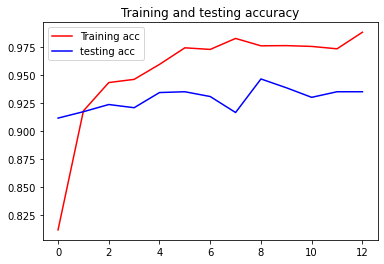

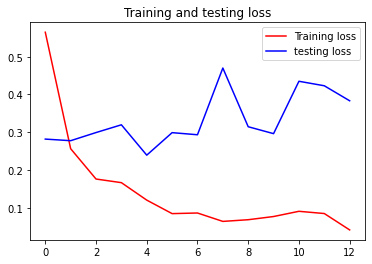

In [93]:
# 모델 학습
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta = 0, patience =4, mode='auto')
model_checkpoint = ModelCheckpoint("./model_save/furniture_vgg16_best.h5", save_best_only=True, verbos=1, save_freq='epoch')

history = new_model.fit(train_data_gen, epochs=30,
                        validation_data=test_data_gen,
                        callbacks=[early_stopping, model_checkpoint])

# new_model.save("./model_save/newVGG16.h5")                        
                        
# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()

# 저장 모델 불러오기
from keras.models import load_model

new_model = load_model("./model_save/furniture_vgg16_best.h5")

In [127]:
### 문제점1 : 만약에 사람들이 책상과 의자를 동시에 판다면?? >>> 오브젝트 디텍션을 이용해야 할듯

img_file = [x for x in os.listdir('./가구이미지')]
img_file

['스탠드1.jpg',
 '스탠드2.jpg',
 '액자1.jpg',
 '액자2.jpg',
 '의자1.jpg',
 '의자2.jpg',
 '책상1.jpg',
 '책상2.jpg',
 '책장1.jpg',
 '책장2.jpg',
 '침대1.jpg',
 '침대2.jpg',
 '화분1.jpg',
 '화분2.jpg']

In [129]:
from PIL import Image
import numpy as np

test_img_list = []
for x in img_file:
        temp_img = Image.open(f'./가구이미지/{x}')
        temp_img = temp_img.resize((224,224))
        temp_img = np.array(temp_img)
        temp_img = np.expand_dims(temp_img, axis=0)
        test_img_list.append([x.split('.')[0], temp_img])

In [130]:
test_img_list

[['스탠드1',
  array([[[[66, 61, 58],
           [66, 61, 58],
           [66, 61, 58],
           ...,
           [70, 65, 62],
           [70, 65, 62],
           [72, 64, 62]],
  
          [[66, 61, 58],
           [66, 61, 58],
           [66, 61, 58],
           ...,
           [70, 65, 62],
           [70, 65, 62],
           [72, 64, 62]],
  
          [[66, 61, 58],
           [66, 61, 58],
           [66, 61, 58],
           ...,
           [70, 65, 62],
           [70, 65, 62],
           [72, 64, 62]],
  
          ...,
  
          [[71, 71, 73],
           [71, 71, 73],
           [71, 71, 73],
           ...,
           [63, 61, 62],
           [63, 61, 62],
           [63, 61, 62]],
  
          [[71, 71, 73],
           [71, 71, 73],
           [71, 71, 73],
           ...,
           [63, 61, 62],
           [63, 61, 62],
           [63, 61, 62]],
  
          [[73, 71, 74],
           [73, 71, 74],
           [72, 70, 73],
           ...,
           [63, 61, 64],
      

orginal: 스탠드1 // predict: chair 100.00%
[0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 7.298368e-17]
orginal: 스탠드2 // predict: stand 100.00%
[0. 0. 0. 0. 0. 0. 1.]
orginal: 액자1 // predict: photoframe 100.00%
[0. 0. 0. 0. 0. 1. 0.]
orginal: 액자2 // predict: photoframe 100.00%
[0. 0. 0. 0. 0. 1. 0.]
orginal: 의자1 // predict: chair 100.00%
[0. 0. 1. 0. 0. 0. 0.]
orginal: 의자2 // predict: chair 100.00%
[0. 0. 1. 0. 0. 0. 0.]
orginal: 책상1 // predict: desk 100.00%
[0. 0. 0. 1. 0. 0. 0.]
orginal: 책상2 // predict: desk 100.00%
[0.0000000e+00 0.0000000e+00 2.5187218e-23 1.0000000e+00 0.0000000e+00
 0.0000000e+00 1.8702037e-26]
orginal: 책장1 // predict: bookshelf 100.00%
[0. 1. 0. 0. 0. 0. 0.]
orginal: 책장2 // predict: bookshelf 100.00%
[0. 1. 0. 0. 0. 0. 0.]
orginal: 침대1 // predict: bed 100.00%
[1. 0. 0. 0. 0. 0. 0.]
orginal: 침대2 // predict: chair 100.00%
[0. 0. 1. 0. 0. 0. 0.]
orginal: 화분1 // predict: flowerpot 100.00%
[0. 0. 0. 0. 1. 0. 0.]
orginal: 화분2 // predict: 

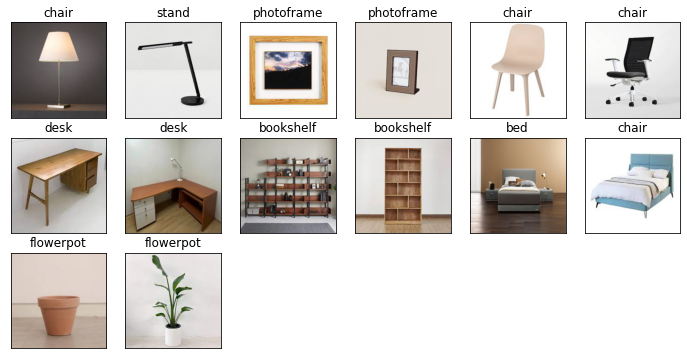

In [152]:
### 이미지 예측해보기
### 이미지 파일 종류
labels = os.listdir('./train_test_dataset/train')
plt.figure(figsize=(12,6))
plt.axis(False)
n = 1
for name, img in test_img_list:

    y_predict = new_model.predict(img)

    label = labels[y_predict[0].argmax()]
    confidence = y_predict[0][y_predict[0].argmax()]
    print('orginal: {} // predict: {} {:.2f}%'.format(name, label, confidence * 100))
    print(y_predict[0])
    
    plt.subplot(3,6,n)
    plt.imshow(img[0])
    plt.title(label)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    n+=1

In [143]:
os.listdir('./train_test_dataset/train')

['bed', 'bookshelf', 'chair', 'desk', 'flowerpot', 'photoframe', 'stand']

In [141]:
train_data_gen.

'channels_last'